In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

import pandas as pd
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime, timedelta
import os

%matplotlib inline

In [2]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0


metaDataIndex = ['time',
                 'lat', 
                 'lon',
                 'U10N_QS',
                 'U10N_dir_QS',
                 'eflags_QS',
                 'num_ambiguity_QS',
                 'satTimeDiff',
                 'dist',
                 'satLon',
                 'satLat',
                 'U10N_TAO',
                 'U10N_dir_TAO',
                 'U10N_TAO2',
                 'U10N_dir_TAO2',
                 'U10N_x_TAO2',
                 'U10N_y_TAO2',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'wspdVar2hr_TAO',
                 'wdirVar2hr_TAO',
                 'Deployment Classifier']
metaData = np.empty((0,len(metaDataIndex)), dtype=float)

for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):

        ds = Dataset(matchFname)
        arr = np.empty((0,1), dtype=float)
        for i in range(3,22):
            if i <= 10:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][0,:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                if len(arr) == 0:
                    arr = np.concatenate((arr, readArr), axis = 0)
                else:
                    arr = np.concatenate((arr, readArr), axis = 1)
            else:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                arr = np.concatenate((arr, readArr), axis = 1)

        latArr = np.array([len(arr)*[LAT]]).T
        lonArr = np.array([len(arr)*[LON]]).T
        timeArr = np.array(ds.variables['time'])

        # latArr = latArr[:,np.newaxis]
        # lonArr = lonArr[:,np.newaxis]
        timeArr = timeArr[:,np.newaxis]
        
        #print('lonArr', lonArr.shape)
        arr = np.concatenate((lonArr, arr), axis=1)

        #print('latArr', latArr.shape)
        arr = np.concatenate((latArr, arr), axis=1)

        #print('timeArr', timeArr.shape)
        arr = np.concatenate((timeArr, arr), axis=1)

        ds2 = Dataset(deployFileName)
        startDates = np.array(ds2.variables['startDate'])
        endDates = np.array(ds2.variables['endDate'])

        depNum = np.zeros((len(arr),1), dtype=int)
        c = 1
        for i in range(1,len(startDates)):
            mask = timeArr >= startDates[i]
            mask *= timeArr <= endDates[i]
            depNum[mask] = c
            c = c+1

        arr = np.concatenate((arr, depNum), axis=1)


        metaData = np.concatenate((metaData, arr), axis=0)
        #ds = ds.expand_dims('lat', axis= 0)
        

KeyError: 'wspdVar2hr_TAO'

In [3]:
nanVals = np.sum(metaData[:,:-2], axis=1)
mask = np.isnan(nanVals)
print(np.sum(mask), metaData.shape)
metaData = metaData[~mask, :]
print(metaData.shape)

7935 (199611, 23)
(191676, 23)


In [4]:
df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['U10N_QS'] - df['U10N_TAO']
df['absSpeedDiff'] = abs(df['U10N_QS'] - df['U10N_TAO'])

dDiff = (df['U10N_dir_QS'] - df['U10N_dir_TAO'])%360
dDiff[dDiff > 180] -= 360 #- dDiff[dDiff > 180] 
dDiff[dDiff < -180] += 360
df['directionDiff'] = dDiff
df['absDirectionDiff'] = abs(dDiff)

In [5]:
df

,time,lat,lon,U10N_QS,U10N_dir_QS,eflags_QS,num_ambiguity_QS,satTimeDiff,dist,satLon,...,SST_TAO,RH_TAO,AIRT_TAO,wspdVar2hr_TAO,wdirVar2hr_TAO,Deployment Classifier,speedDiff,absSpeedDiff,directionDiff,absDirectionDiff
0,315704400.0,-8.0,265.0,6.211579,323.708984,5.0,2.0,271.0,6.615148,264.974976,...,23.938000,75.730003,23.200001,0.242370,12.575223,0.0,0.670052,0.670052,2.408997,2.408997
1,315705000.0,-8.0,265.0,6.211579,323.708984,5.0,2.0,-329.0,6.615148,264.974976,...,23.927999,75.599998,23.190001,0.257944,14.344487,0.0,0.218719,0.218719,3.108978,3.108978
2,315749400.0,-8.0,265.0,5.837174,318.623627,5.0,3.0,457.0,5.688329,265.045563,...,23.716999,73.879997,23.040001,0.153811,34.936054,0.0,-0.218190,0.218190,0.823639,0.823639
3,315750000.0,-8.0,265.0,5.837174,318.623627,5.0,3.0,-143.0,5.688329,265.045563,...,23.718000,74.309998,23.110001,0.186740,48.046122,0.0,-0.525142,0.525142,-6.776367,6.776367
4,315834600.0,-8.0,265.0,6.193676,327.747528,5.0,4.0,153.0,3.979192,265.025726,...,23.789000,75.019997,22.940001,2.341721,284.572503,0.0,0.331379,0.331379,-24.352478,24.352478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
191671,536339400.0,9.0,220.0,9.060904,251.005539,5.0,2.0,-42.0,6.435526,219.981033,...,26.754999,94.370003,25.299999,1.573013,66.133436,10.0,2.689547,2.689547,17.005539,17.005539
191672,536384400.0,9.0,220.0,10.913956,239.481735,4353.0,2.0,86.0,0.888303,219.992020,...,26.757000,88.559998,26.260000,0.264562,8.611401,10.0,0.276167,0.276167,7.981735,7.981735
191673,536385000.0,9.0,220.0,10.913956,239.481735,4353.0,2.0,-514.0,0.888303,219.992020,...,26.754999,88.000000,26.270000,0.341049,8.003300,10.0,0.433704,0.433704,7.181732,7.181732
191674,536424000.0,9.0,220.0,10.722863,244.993149,5.0,4.0,205.0,1.812441,219.997299,...,26.660999,93.629997,25.110001,0.536636,25.682315,10.0,-1.017040,1.017040,10.993149,10.993149


In [6]:
selectX = [#'time',
           #'U10N_QS',
           #'U10N_dir_QS',
           #'satTimeDiff',
           #'dist',
           #'U10N_TAO',
           #'U10N_dir_TAO',
           #'U10N_x_TAO2',
           #'U10N_y_TAO2',
           #'SST_TAO',
           #'RH_TAO',
           #'AIRT_TAO',
           'speedDiff',
           'directionDiff',
           #'absSpeedDiff',
           #'absDirectionDiff'
            ]

X = df[selectX]

In [7]:
X.head()

,speedDiff,directionDiff
0,0.670052,2.408997
1,0.218719,3.108978
2,-0.218190,0.823639
3,-0.525142,-6.776367
4,0.331379,-24.352478


In [8]:
normX = (X - X.mean(axis=0))/ X.std(axis=0)

In [9]:
normX

,speedDiff,directionDiff
0,0.370905,0.069112
1,0.013489,0.091751
2,-0.332504,0.017837
3,-0.575582,-0.227969
4,0.102706,-0.796429
...,...,...
191671,1.970165,0.541205
191672,0.058983,0.249350
191673,0.183738,0.223475
191674,-0.965122,0.346747


In [10]:
# normX['errorFrmNorm'] = np.sqrt(normX['absSpeedDiff']**2 + normX['absDirectionDiff']**2)
# X=normX['errorFrmNorm']

In [11]:
# Y = X.to_numpy()

In [12]:
# Y = np.array([Y]).transpose()
# Y.shape

(0.20168709853317138, 1.262767622454958, 0.8449428807173319)

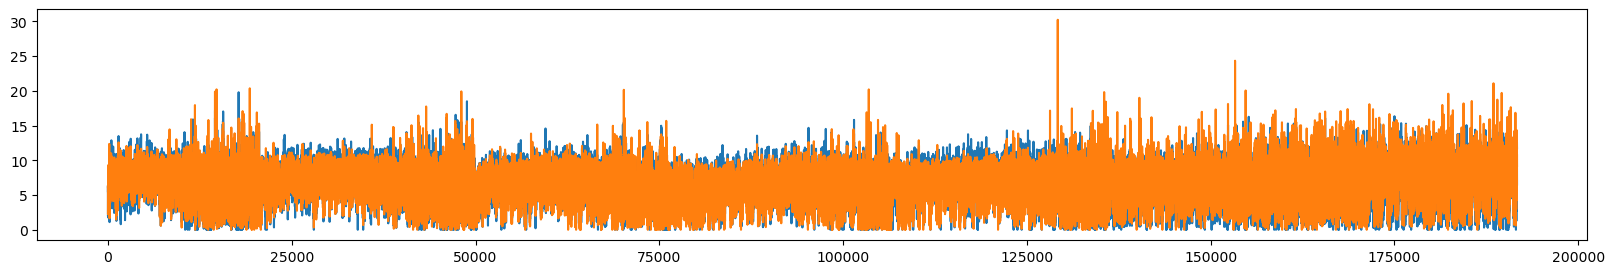

In [13]:
n1= 0
n2 = -1
plt.figure(figsize=(20,3))
plt.plot(df['U10N_TAO'][n1:n2])
plt.plot(df['U10N_QS'][n1:n2])
np.mean(df['U10N_QS'][n1:n2]-df['U10N_TAO'][n1:n2]), np.std(df['U10N_QS'][n1:n2]-df['U10N_TAO'][n1:n2]), np.corrcoef(df['U10N_TAO'][n1:n2], df['U10N_QS'][n1:n2])[0,1]

(6.115097742919873, 58.359819574881165, 0.691545073759642)

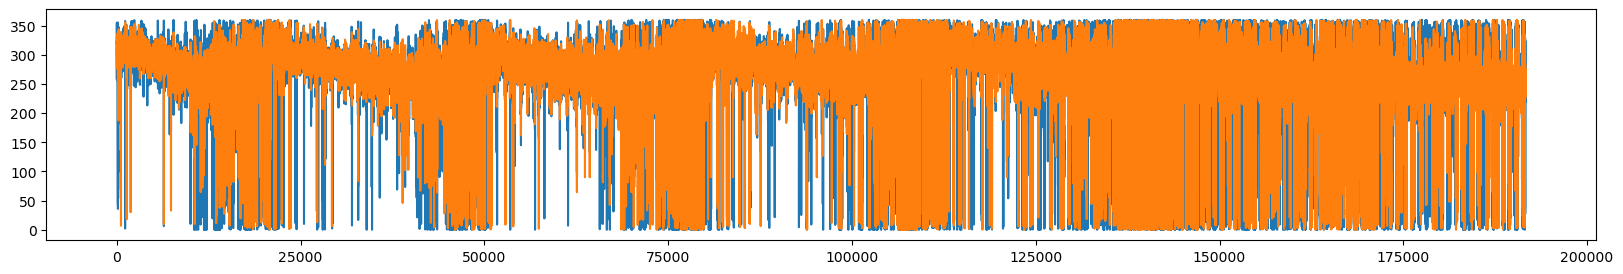

In [14]:
n1= 0
n2 = -1
plt.figure(figsize=(20,3))
plt.plot(df['U10N_dir_TAO'][n1:n2])
plt.plot(df['U10N_dir_QS'][n1:n2])
np.mean(df['U10N_dir_QS'][n1:n2]-df['U10N_dir_TAO'][n1:n2]), np.std(df['U10N_dir_QS'][n1:n2]-df['U10N_dir_TAO'][n1:n2]), np.corrcoef(df['U10N_dir_TAO'][n1:n2], df['U10N_dir_QS'][n1:n2])[0,1]

In [15]:
kmeans = KMeans(n_clusters=9, random_state=0, n_init="auto", max_iter = 10000).fit(normX)
df['label'] = kmeans.labels_

In [16]:
def plotTimeSeriesByClusterLabel(df, lat, lon, ax1, ax2, cluster_label=0, color='blue'):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    subDF = subDF.loc[subDF['label'] == cluster_label]

    if lat < 0:
        latUnits = 'S'
        lat = abs(lat)
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        lon = abs(lon) # 360
    else:
        lonUnits = 'E'

    
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    ds2 = Dataset(deployFileName)
    startDates = np.array(ds2.variables['startDate'])
    units = ds2.variables['startDate'].units
    cftimes = num2date(startDates, units)
    startDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    endDates = np.array(ds2.variables['endDate'])
    units = ds2.variables['endDate'].units
    cftimes = num2date(endDates, units)
    endDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])

    ds2.close()
    
    cftimes = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')
    dates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute) for dtm in cftimes])
    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']

    for i in range(len(startDates)):
        colorR =list(np.random.choice(range(256), size=3)/256)
        
        ax1.axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
        ax2.axvspan(startDates[i], endDates[i], 
                   alpha=0.05, color=colorR)
    
    #ax1.scatter(subDF['time'], y1, s=2, label = cluster_label)#, c = subDF['label'])
    #ax2.scatter(subDF['time'], y2, s=2, label = cluster_label)#, c = subDF['label'])

    ax1.scatter(dates, y1, s=3, label = cluster_label, c = color)
    ax2.scatter(dates, y2, s=3, label = cluster_label, c = color)
    ax1.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} speed Diff')
    ax2.set_title(f'{lat:02d}{latUnits} {lon:03d}{lonUnits} direction Diff')

def plotTimeSeriesAllClusterLabel(df, lat, lon, ax1, ax2):
    subDF = df.loc[df['lat'] == lat]
    subDF = subDF.loc[subDF['lon'] == lon%360]
    
    
    dates = num2date(subDF['time'], 'seconds since 1990-01-01 00:00:00')

    y1 = subDF['speedDiff']
    y2 = subDF['directionDiff']
    
    ax1.scatter(subDF['time'], y1, s=2, c = subDF['Deployment Classifier'], cmap='prism')
    ax2.scatter(subDF['time'], y2, s=2, c = subDF['Deployment Classifier'], cmap='prism')

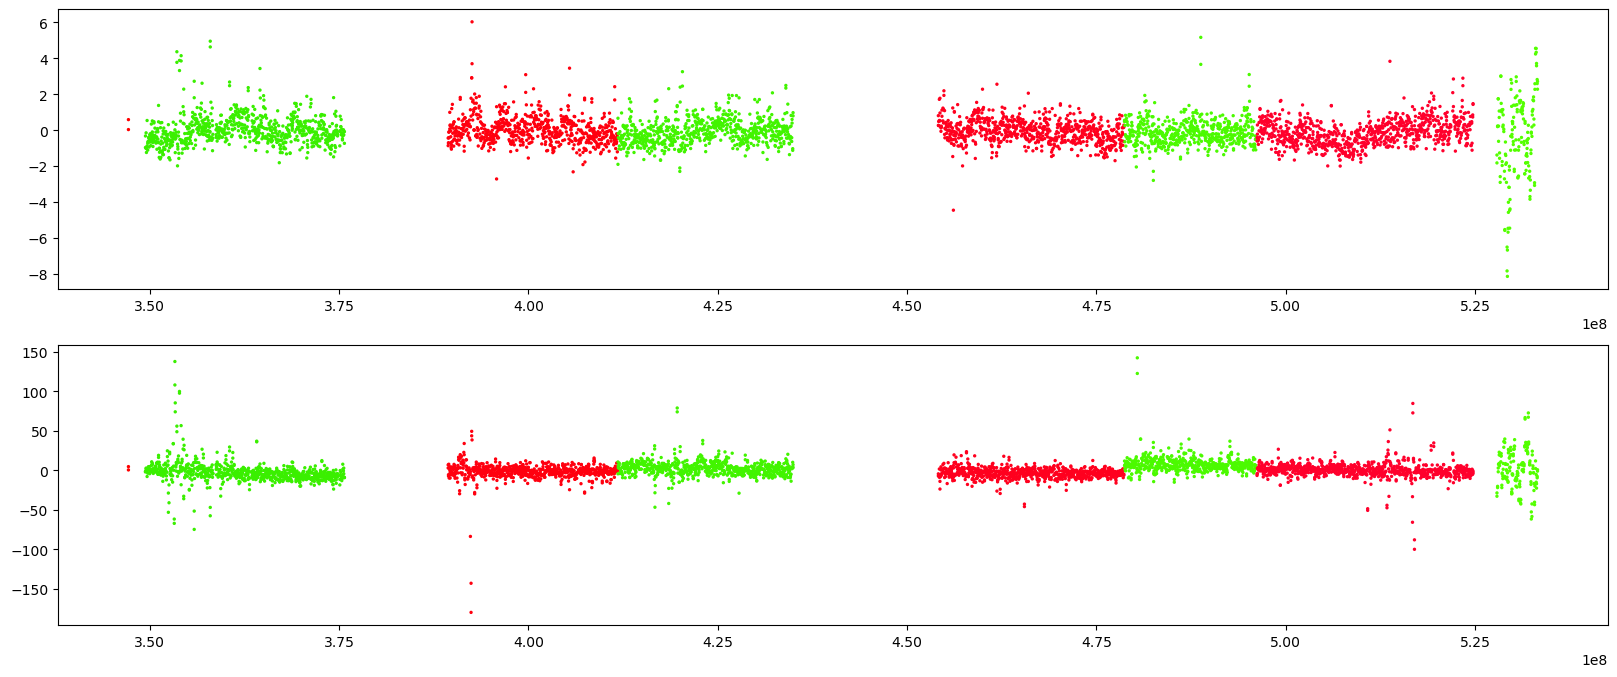

In [17]:
lat = -2
lon = -140

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesAllClusterLabel(df, lat, lon, axes[0], axes[1])

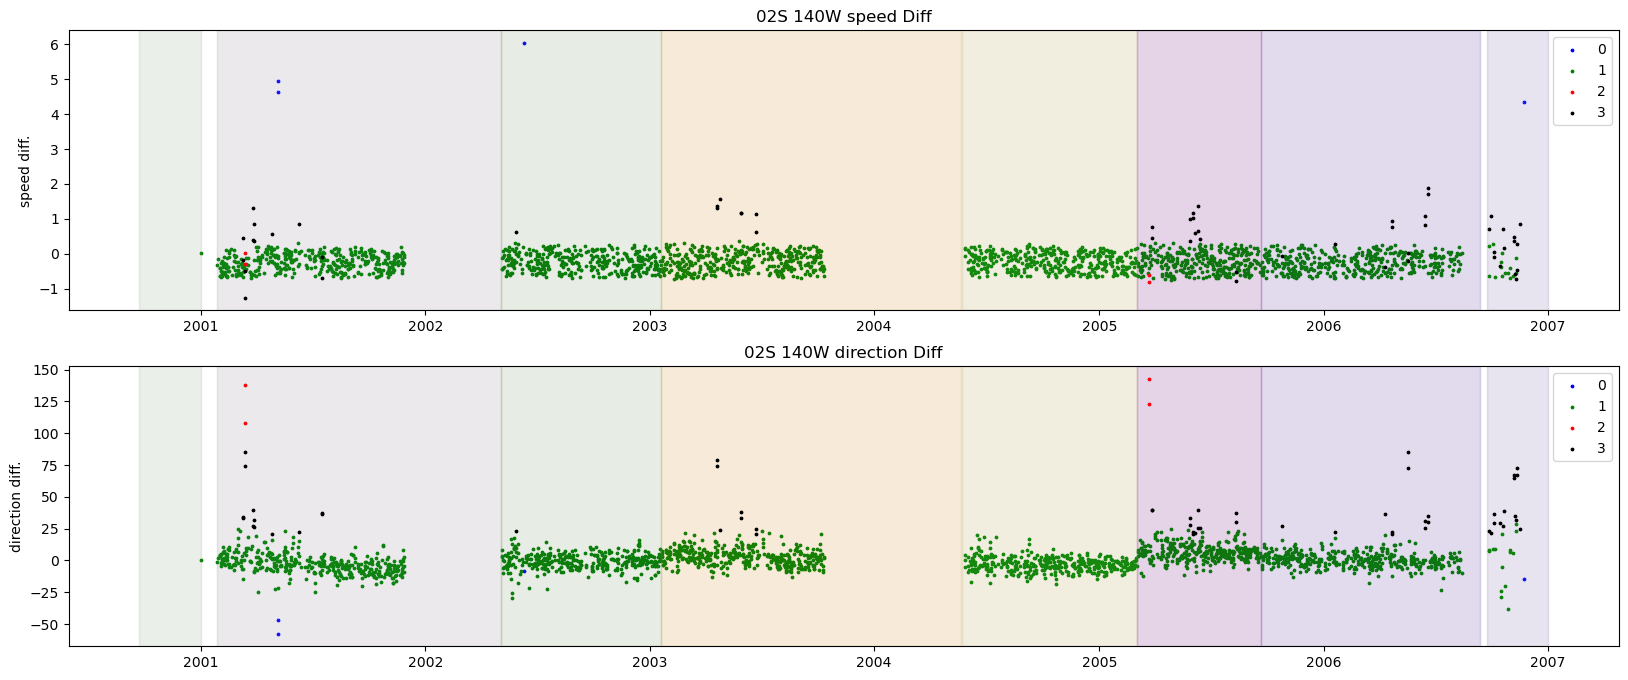

In [18]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20,8))
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=0, color = 'blue')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=1, color = 'green')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=2, color = 'red')
plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=3, color = 'black')
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=4)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=5)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=6)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=7)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=8)
# plotTimeSeriesByClusterLabel(df, lat, lon, axes[0], axes[1], cluster_label=9)
axes[0].set_ylabel('speed diff.')
axes[0].legend()

axes[1].set_ylabel('direction diff.')
axes[1].legend()

In [19]:
df.head()

,time,lat,lon,U10N_QS,U10N_dir_QS,eflags_QS,num_ambiguity_QS,satTimeDiff,dist,satLon,...,RH_TAO,AIRT_TAO,wspdVar2hr_TAO,wdirVar2hr_TAO,Deployment Classifier,speedDiff,absSpeedDiff,directionDiff,absDirectionDiff,label
0,315704400.0,-8.0,265.0,6.211579,323.708984,5.0,2.0,271.0,6.615148,264.974976,...,75.730003,23.200001,0.242370,12.575223,0.0,0.670052,0.670052,2.408997,2.408997,4
1,315705000.0,-8.0,265.0,6.211579,323.708984,5.0,2.0,-329.0,6.615148,264.974976,...,75.599998,23.190001,0.257944,14.344487,0.0,0.218719,0.218719,3.108978,3.108978,1
2,315749400.0,-8.0,265.0,5.837174,318.623627,5.0,3.0,457.0,5.688329,265.045563,...,73.879997,23.040001,0.153811,34.936054,0.0,-0.218190,0.218190,0.823639,0.823639,1
3,315750000.0,-8.0,265.0,5.837174,318.623627,5.0,3.0,-143.0,5.688329,265.045563,...,74.309998,23.110001,0.186740,48.046122,0.0,-0.525142,0.525142,-6.776367,6.776367,1
4,315834600.0,-8.0,265.0,6.193676,327.747528,5.0,4.0,153.0,3.979192,265.025726,...,75.019997,22.940001,2.341721,284.572503,0.0,0.331379,0.331379,-24.352478,24.352478,4


In [20]:
import seaborn as sns

In [21]:
#sns.pairplot(data=df, x = 'hue="label")

In [22]:
subDFheaders = ['satTimeDiff',
                 'dist',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'speedDiff',
                 'directionDiff',
                 'absSpeedDiff',
                 'absDirectionDiff',
                 'label']

subDFheaders = [ 'satTimeDiff',
                 'dist',
                 # 'SST_TAO',
                 # 'RH_TAO',
                 # 'AIRT_TAO',
                 'speedDiff',
                 'directionDiff',
                 #'absSpeedDiff',
                 #'absDirectionDiff',
                 'label']

subDF = df[subDFheaders]

In [23]:
#snsPlot = sns.pairplot(data=subDF, hue="label")

In [24]:
#snsPlot.figure.savefig('allData.png', dpi = 100)

In [25]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=False, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=False, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensityClusteringJustByErrorsCommonNormFalse.png', dpi = 100)

In [26]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=False, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=False, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('timeAndSpaceDistProbDensityClusteringJustByErrorsCommonNormFalse.png', dpi = 100)

In [27]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=True, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=True, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('allDataProbDensityClusteringJustByErrorsCommonNormTrue.png', dpi = 100)

In [28]:
# g = sns.PairGrid(subDF, hue="label", palette = sns.color_palette("bright"), corner=True)
# g.map_lower(sns.kdeplot, common_norm=True, levels=20, linewidths=0.75)
# g.map_diag(sns.histplot, common_norm=True, element="step", linewidth=0, kde=True)
# g.add_legend(frameon=True)
# g.legend.set_bbox_to_anchor((.61, .6))
# g.figure.savefig('timeAndSpaceDistProbDensityClusteringJustByErrorsCommonNormTrue.png', dpi = 100)

In [29]:
# xlabel = 'directionDiff'
# s = sns.kdeplot(subDF, x=xlabel, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [30]:
# xlabel = 'speedDiff'
# s = sns.kdeplot(subDF, x=xlabel, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [31]:
# xlabel = 'absSpeedDiff'
# ylabel = 'absDirectionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [32]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"))

In [33]:
# fig,  ax = plt.subplots(figsize=(8,6))
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'

# cmap = plt.get_cmap('Greys').copy()
# cmap.set_bad('white')

# h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
#                        norm=colors.LogNorm())
# cb = plt.colorbar(h1[3], ax = ax)
# cb.ax.set_title('Count')

# sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
#                     levels=20, linewidths=0.5, 
#                     palette = sns.color_palette("bright"), ax = ax)

# ax.grid(visible=True, which='both', axis='both')
# ax.set_xlim(-10,15)
# ax.set_xlabel('QS speed - TAO speed [m/s]')
# ax.set_ylabel('QS direction - TAO direction [Degrees]')
# #plt.savefig('PDF_byCluster.png', dpi=100)

In [34]:
# fig,  ax = plt.subplots(figsize=(8,6))
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'

# # sA = sns.kdeplot(subDF, x=xlabel, y=ylabel,
# #                     levels=20, linewidths=0.5, 
# #                     palette = sns.color_palette("bright"), ax = ax)
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"), ax = ax)

# ax.grid(visible=True, which='both', axis='both')
# ax.set_xlabel('QS speed - TAO speed [m/s]')
# ax.set_ylabel('QS direction - TAO direction [Degrees]')
# ax.set_xlim(-10,15)
# plt.savefig('PDF_byCluster.png', dpi=100)


In [ ]:
# fig,  ax = plt.subplots(figsize=(8,6))
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# subdf = df.loc[df['label'].isin([0,2,3,5,6,8])]
# s = sns.kdeplot(subdf, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', common_norm=False,
#                 palette = sns.color_palette("bright"), ax = ax)

# ax.grid(visible=True, which='both', axis='both')

In [35]:
# sns.set_style("whitegrid")
# tips = sns.load_dataset("tips")
# box_plot = sns.boxplot(x="day",y="total_bill",data=tips)

# medians = tips.groupby(['day'])['total_bill'].median()
# vertical_offset = tips['total_bill'].median() * 0.05 # offset from median for display

# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
#             horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [36]:
# fig, ax = plt.subplots(figsize = (20,15))
# box_plot = sns.boxplot(df, x="label",y="speedDiff", ax = ax)

# medians = df.groupby(['label'])['speedDiff'].median()
# vertical_offset = df['speedDiff'].median() * 0.05 # offset from median for display

# for xtick in box_plot.get_xticks():
#     box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
#             horizontalalignment='center',size='x-small',color='w',weight='semibold')

In [37]:
var = 'speedDiff'
labelVal = 0

def getPDFplotFor(ax, df, labelVal, var):
    sns.histplot(df.loc[df['label'] == labelVal], x = var, ax = ax, bins = 50)
    ax.axvline(x = medians[labelVal], ymin= 0 , ymax = 0.25, color = 'r',  label = 'median')
    ax.axvline(x = means[labelVal], ymin= 0 , ymax = 0.25, color = 'blue',linestyle = '--', label = 'mean')
    ax.axvline(x = means[labelVal]-stdDevs[labelVal],  ymin= 0 , ymax = 0.25, color = 'orange', label = 'std. Dev')
    ax.axvline(x = means[labelVal]+stdDevs[labelVal],  ymin= 0 , ymax = 0.25, color = 'orange')
    
    text = f' mean: {means[labelVal]:6.2f} \n median: {medians[labelVal]:6.2f} \n stdDev: {stdDevs[labelVal]:6.2f}'
    
    
    ax.text(0.05, 0.95, text, horizontalalignment='left',
         verticalalignment='top', transform=ax.transAxes,
         bbox=dict(facecolor='white', alpha= 0.5))
    ax.legend(loc='upper right')

In [38]:
# var = 'speedDiff'

# medians = df.groupby(['label'])[var].median()
# means = df.groupby(['label'])[var].mean()
# stdDevs = df.groupby(['label'])[var].std()

# fig,  axes = plt.subplots(nrows=2, ncols=4, figsize=(20,12))

# for labelVal in range(8):
#     ii = int(labelVal//4)
#     jj = labelVal%4
#     print(ii, jj)
#     ax = axes[ii,jj]
#     getPDFplotFor(ax, df, labelVal, var)
#     ax.set_title('Cluster: '+ str(labelVal))
    

In [39]:
# var = 'directionDiff'

# medians = df.groupby(['label'])[var].median()
# means = df.groupby(['label'])[var].mean()
# stdDevs = df.groupby(['label'])[var].std()

# fig,  axes = plt.subplots(nrows=2, ncols=4, figsize=(20,12))

# for labelVal in range(8):
#     ii = int(labelVal//4)
#     jj = labelVal%4
#     print(ii, jj)
#     ax = axes[ii,jj]
#     getPDFplotFor(ax, df, labelVal, var)
#     ax.set_title('Cluster: '+ str(labelVal))


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 0, 'cluster label')

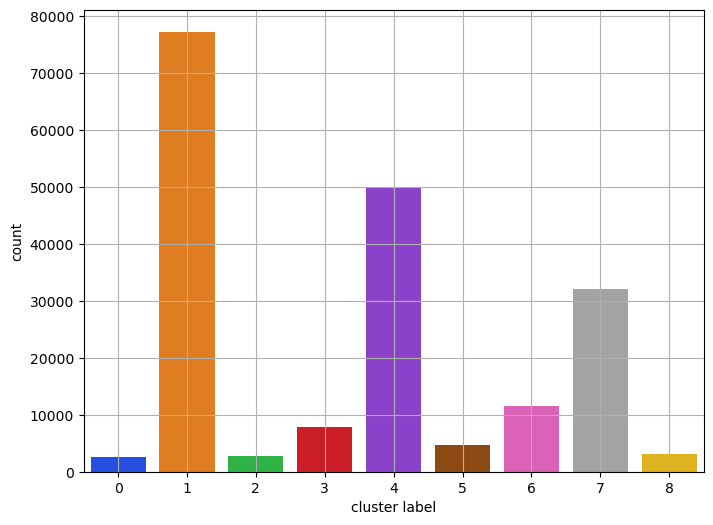

In [40]:
fig,  ax = plt.subplots(figsize=(8,6))
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

In [41]:
goodBad = np.array(['good' for i in range(len(df))])
print(len(goodBad))
mask = df['label'].isin([0,2,3,5,6,8])
goodBad[mask] = 'bad'
df['GoodBad'] = goodBad

191676


In [42]:
def getGoodBad(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        if len(subDF) != 0:
            goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
            badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        else:
            goodCount = np.nan
            badCount = np.nan
        
        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        if len(subDF) != 0:
            goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
            badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        else:
            goodCount = np.nan
            badCount = np.nan
            
        # goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        # badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999
    

In [43]:
getGoodBad(0, -140, df), getBadPercent(0, -140, df), 

('  96,  4', 4.210918576485932)

total num of matchups 191676


Text(0.5, 1.0, '% of Bad Data')

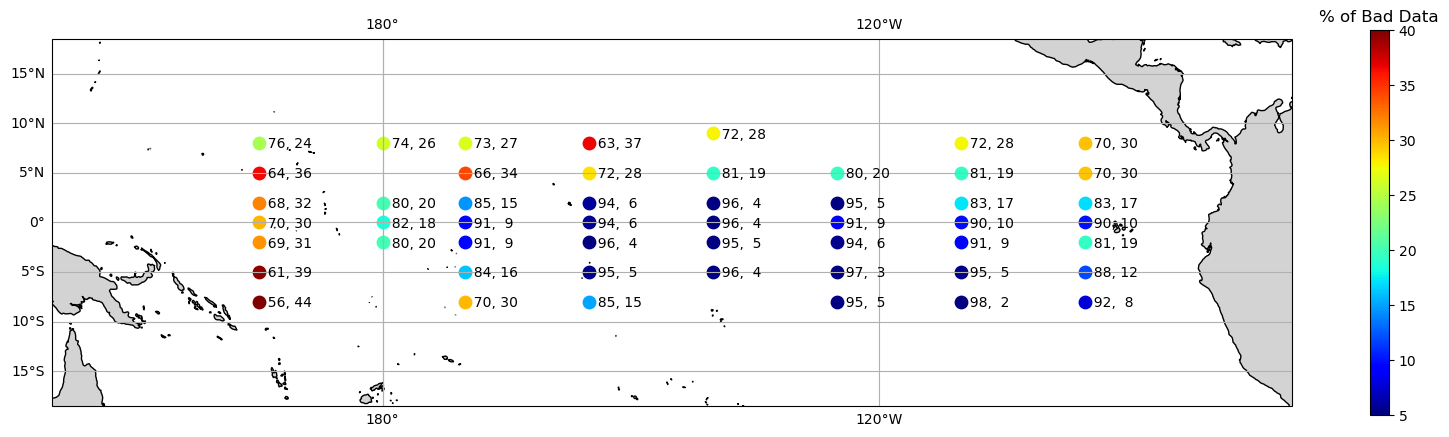

In [44]:
print(f'total num of matchups {len(df)}')
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=5, vmax=40, s=80, cmap='jet')
    
cb = plt.colorbar(x)
cb.ax.set_title('% of Bad Data')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())


#plt.savefig('goodVsBad.png', dpi=100)
    


In [45]:


flags = np.sort(np.array(df['eflags_QS'].unique()))

def getGoodBadPlotsByFlags(flagIndex,):
    subDF = df.loc[df['eflags_QS'] == flags[flagIndex] ]
    subDF = subDF.drop("GoodBad", axis=1)
    goodBad = np.array(['good' for i in range(len(subDF))])
    
    mask = subDF['label'].isin([0,2,3,5,6,8])
    goodBad[mask] = 'bad'
    subDF['GoodBad'] = goodBad
    
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature 
    fig, ax = plt.subplots(nrows = 1, 
                           ncols = 1, 
                            figsize = (20,5),
                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                           gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 
    
    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',
        facecolor='lightgrey'  # Set the color to grey
    )
    
    ax.add_feature(land)
    
    #ax = axes[0]
    ax.set_extent([140, -70, -5, 5]) 
    gridlines = ax.gridlines(draw_labels=True)
    ax.coastlines()
    for task in taskList:
        lat = task[0]
        lon = task[1]
        txt = getGoodBad(lat, lon, subDF)
        
    
        xpos = lon + 180
        
        if xpos > 180:
           xpos -= 360
        if txt != '': 
            badPercent = getBadPercent(lat, lon, subDF)
            #print(badPercent)
            ax.text(xpos, lat-0.5, txt)
            x = ax.scatter(xpos, lat, c=badPercent, vmin=5, vmax=40, s=80, cmap='jet')


    ax.text(0.1,0.98, f'flag Index: {flagIndex}', 
            horizontalalignment='left', 
            verticalalignment='center', 
            transform=ax.transAxes)
    
    ax.text(0.1,0.95, f'total num of matchups {len(df)}', 
            horizontalalignment='left', 
            verticalalignment='center', 
            transform=ax.transAxes)
    ax.text(0.1,0.9, f'num of matchups for this plot {len(subDF)}', 
            horizontalalignment='left', 
            verticalalignment='center', 
            transform=ax.transAxes)
    cb = plt.colorbar(x)
    cb.ax.set_title('% of Bad Data')
    
    plt.savefig(f'flag_index_{flagIndex}.png', dpi=100)

    plt.close()

    return len(subDF), len(subDF.loc[subDF['GoodBad'] == 'bad'])


num_matchups_eachFlags = np.zeros((len(flags)), dtype=int)
num_bad_eachFlags = np.zeros((len(flags)), dtype=int)

for flagIndex in range(len(flags)):
    num_matchups_eachFlags[flagIndex], num_bad_eachFlags[flagIndex] = getGoodBadPlotsByFlags(flagIndex)
    

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transform_point(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/pyproj/transformer.py:820: UserWarning: Warning: converting a masked element to nan.
  return self._transformer._transfo

Text(0.5, 1.0, '% of Bad Data')

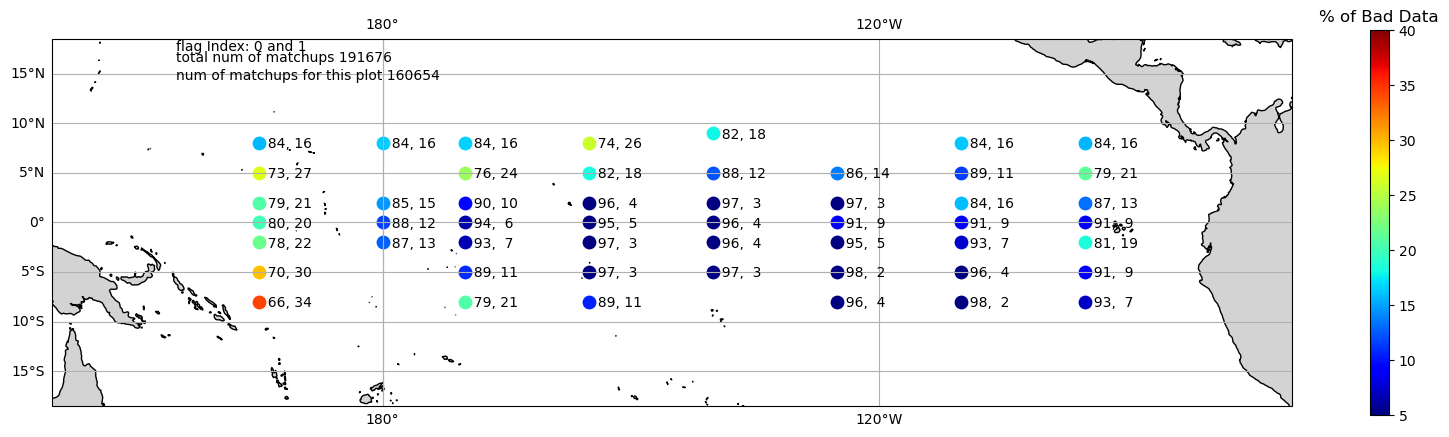

In [46]:
subDF = df.loc[df['eflags_QS'] < flags[2] ]
subDF = subDF.drop("GoodBad", axis=1)
goodBad = np.array(['good' for i in range(len(subDF))])

mask = subDF['label'].isin([0,2,3,5,6,8])
goodBad[mask] = 'bad'
subDF['GoodBad'] = goodBad

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, subDF)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=5, vmax=40, s=80, cmap='jet')


ax.text(0.1,0.98, f'flag Index: 0 and 1', 
        horizontalalignment='left', 
        verticalalignment='center', 
        transform=ax.transAxes)

ax.text(0.1,0.95, f'total num of matchups {len(df)}', 
        horizontalalignment='left', 
        verticalalignment='center', 
        transform=ax.transAxes)
ax.text(0.1,0.9, f'num of matchups for this plot {len(subDF)}', 
        horizontalalignment='left', 
        verticalalignment='center', 
        transform=ax.transAxes)
cb = plt.colorbar(x)
cb.ax.set_title('% of Bad Data')

In [47]:
flags = np.sort(np.array(df['num_ambiguity_QS'].unique()))

def getGoodBadPlotsByFlags(flagIndex,):
    subDF = df.loc[df['num_ambiguity_QS'] == flags[flagIndex] ]
    subDF = subDF.drop("GoodBad", axis=1)
    goodBad = np.array(['good' for i in range(len(subDF))])
    
    mask = subDF['label'].isin([0,2,3,5,6,8])
    goodBad[mask] = 'bad'
    subDF['GoodBad'] = goodBad
    
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature 
    fig, ax = plt.subplots(nrows = 1, 
                           ncols = 1, 
                            figsize = (20,5),
                           subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                           gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 
    
    land = cfeature.NaturalEarthFeature(
        category='physical',
        name='land',
        scale='50m',
        facecolor='lightgrey'  # Set the color to grey
    )
    
    ax.add_feature(land)
    
    #ax = axes[0]
    ax.set_extent([140, -70, -5, 5]) 
    gridlines = ax.gridlines(draw_labels=True)
    ax.coastlines()
    for task in taskList:
        lat = task[0]
        lon = task[1]
        txt = getGoodBad(lat, lon, subDF)
        
    
        xpos = lon + 180
        
        if xpos > 180:
           xpos -= 360
        if txt != '': 
            badPercent = getBadPercent(lat, lon, subDF)
            #print(badPercent)
            ax.text(xpos, lat-0.5, txt)
            x = ax.scatter(xpos, lat, c=badPercent, vmin=5, vmax=40, s=80, cmap='jet')


    ax.text(0.1,0.98, f'num_ambguity: {flagIndex+1}', 
            horizontalalignment='left', 
            verticalalignment='center', 
            transform=ax.transAxes)
    
    ax.text(0.1,0.95, f'total num of matchups {len(df)}', 
            horizontalalignment='left', 
            verticalalignment='center', 
            transform=ax.transAxes)
    ax.text(0.1,0.9, f'num of matchups for this plot {len(subDF)}', 
            horizontalalignment='left', 
            verticalalignment='center', 
            transform=ax.transAxes)
    cb = plt.colorbar(x)
    cb.ax.set_title('% of Bad Data')
    
    plt.savefig(f'num_ambiguity_{flagIndex}.png', dpi=100)

    plt.close()

    return len(subDF), len(subDF.loc[subDF['GoodBad'] == 'bad'])


num_matchups_eachFlags = np.zeros((len(flags)), dtype=int)
num_bad_eachFlags = np.zeros((len(flags)), dtype=int)

for flagIndex in range(len(flags)):
    num_matchups_eachFlags[flagIndex], num_bad_eachFlags[flagIndex] = getGoodBadPlotsByFlags(flagIndex)
    

Text(0, 0.5, 'percent of bad matchup')

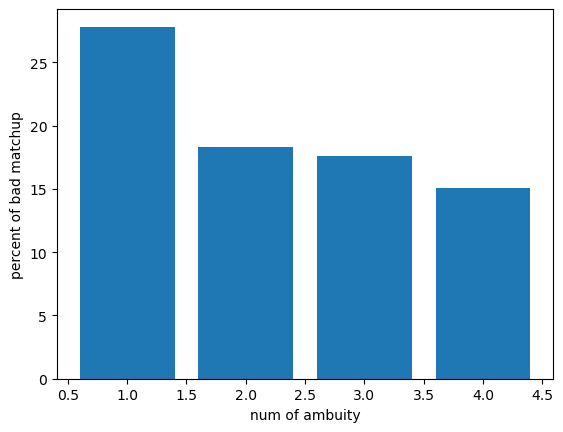

In [48]:
ratio = num_bad_eachFlags/num_matchups_eachFlags * 100

plt.bar(np.arange(1,5),ratio)
plt.xlabel('num of ambuity')
plt.ylabel('percent of bad matchup')

Text(0, 0.5, 'percent of data with this ambuity')

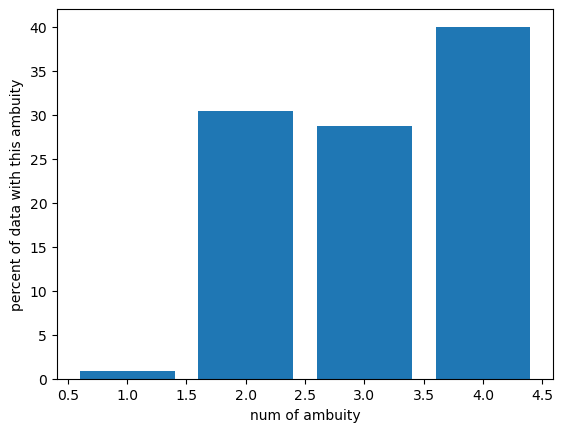

In [49]:
ratio = num_matchups_eachFlags/len(df) * 100

plt.bar(np.arange(1,5),ratio)
plt.xlabel('num of ambuity')
plt.ylabel('percent of data with this ambuity')

In [50]:
df.head()

,time,lat,lon,U10N_QS,U10N_dir_QS,eflags_QS,num_ambiguity_QS,satTimeDiff,dist,satLon,...,AIRT_TAO,wspdVar2hr_TAO,wdirVar2hr_TAO,Deployment Classifier,speedDiff,absSpeedDiff,directionDiff,absDirectionDiff,label,GoodBad
0,315704400.0,-8.0,265.0,6.211579,323.708984,5.0,2.0,271.0,6.615148,264.974976,...,23.200001,0.242370,12.575223,0.0,0.670052,0.670052,2.408997,2.408997,4,good
1,315705000.0,-8.0,265.0,6.211579,323.708984,5.0,2.0,-329.0,6.615148,264.974976,...,23.190001,0.257944,14.344487,0.0,0.218719,0.218719,3.108978,3.108978,1,good
2,315749400.0,-8.0,265.0,5.837174,318.623627,5.0,3.0,457.0,5.688329,265.045563,...,23.040001,0.153811,34.936054,0.0,-0.218190,0.218190,0.823639,0.823639,1,good
3,315750000.0,-8.0,265.0,5.837174,318.623627,5.0,3.0,-143.0,5.688329,265.045563,...,23.110001,0.186740,48.046122,0.0,-0.525142,0.525142,-6.776367,6.776367,1,good
4,315834600.0,-8.0,265.0,6.193676,327.747528,5.0,4.0,153.0,3.979192,265.025726,...,22.940001,2.341721,284.572503,0.0,0.331379,0.331379,-24.352478,24.352478,4,good


In [51]:
def getStdDev2HrWinds(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        if len(subDF) != 0:
            Variance = subDF['wspdVar2hr_TAO']
            #print(Variance)
            stdDev = np.nanmean(Variance)
        else:
            stdDev = np.nan
        return stdDev
    else:
        return -10000

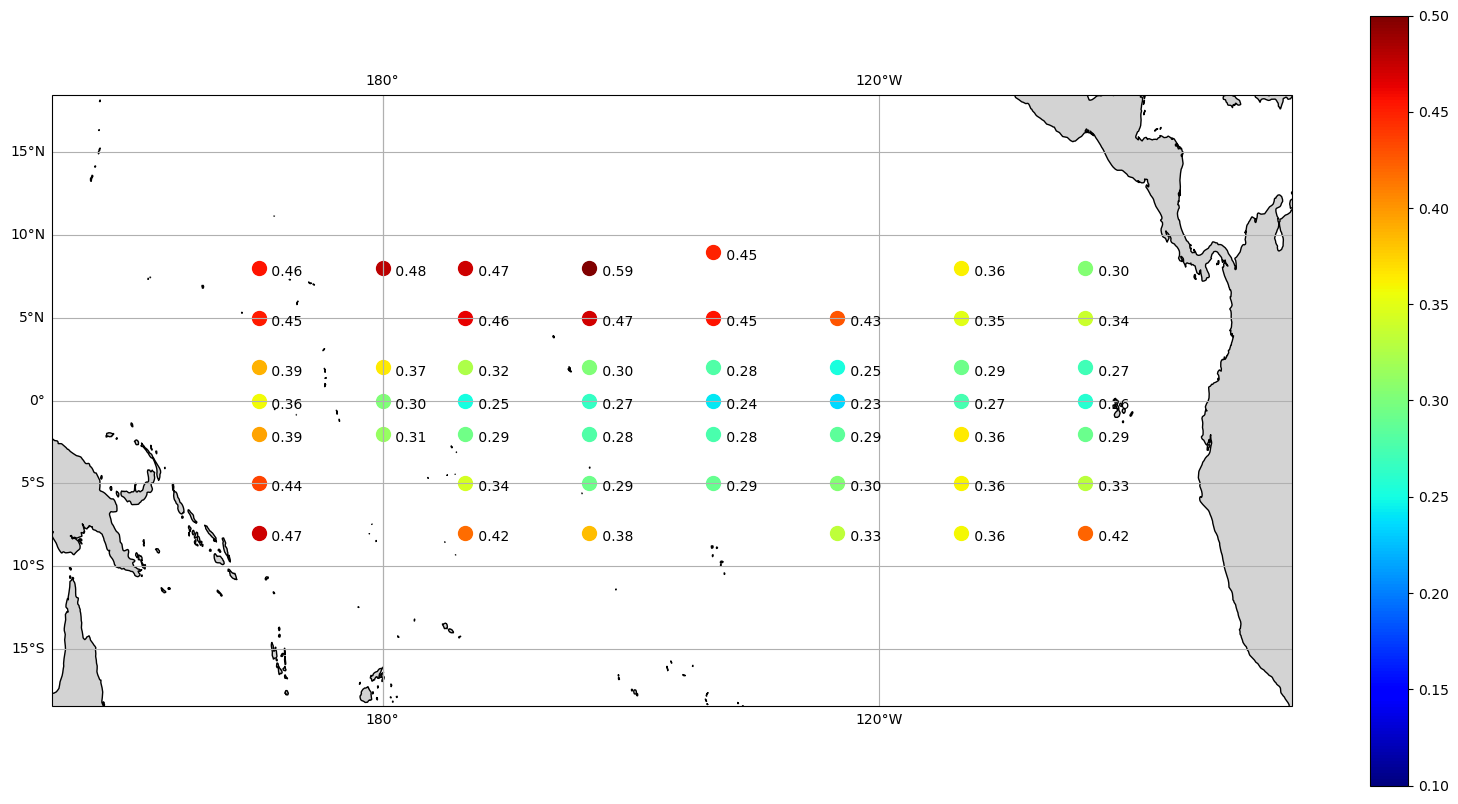

In [52]:
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,10),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    meanVar = getStdDev2HrWinds(lat, lon, subDF)
    txt = f'{meanVar:5.2f}'
    
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if meanVar > 0: 
        #badPercent = getBadPercent(lat, lon, subDF)
        #print(badPercent)
        ax.text(xpos+1, lat-0.5,txt, fontsize=10)
        x = ax.scatter(xpos, lat, c=meanVar, s=100, vmin=0.1, vmax=0.5,cmap='jet') 

cb = plt.colorbar(x)
# cb.ax.set_title('mean of 2 hr variances')

In [53]:
def getStdDev2HrWindsDir(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        if len(subDF) != 0:
            Variance = subDF['wdirVar2hr_TAO']
            #print(Variance)
            stdDev = np.nanmean(Variance)
        else:
            stdDev = np.nan
        return stdDev
    else:
        return -10000

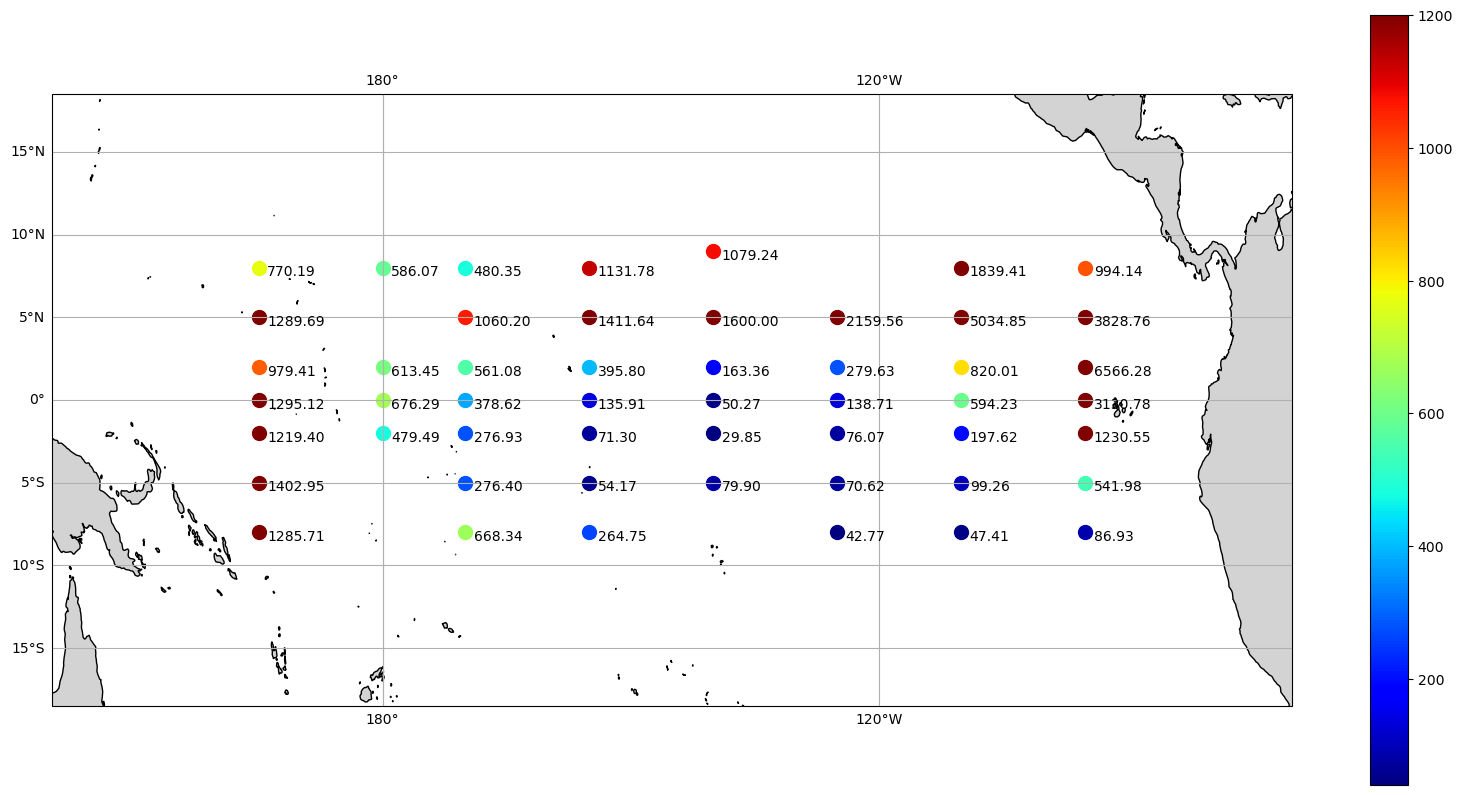

In [55]:
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,10),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    meanVar = getStdDev2HrWindsDir(lat, lon, subDF)
    txt = f'{meanVar:5.2f}'
    
    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if meanVar > 0: 
        #badPercent = getBadPercent(lat, lon, subDF)
        #print(badPercent)
        ax.text(xpos+1, lat-0.5,txt, fontsize=10)
        x = ax.scatter(xpos, lat, c=meanVar, s=100, vmin=40, vmax=1200,cmap='jet') 

cb = plt.colorbar(x)
# cb.ax.set_title('mean of 2 hr variances')

In [ ]:
fig,  ax = plt.subplots(figsize=(8,6))
xlabel = 'speedDiff'
ylabel = 'directionDiff'
s = sns.countplot(df, x='label',palette = sns.color_palette("bright"), ax = ax)

ax.grid(visible=True, which='both', axis='both')
ax.set_xlabel('cluster label')
#ax.set_ylabel('cluster label')

In [ ]:
df['num_ambiguity_QS'].unique()

In [ ]:
#subDF = df.loc[df['eflags_QS'] == 1.0]
subDF = df.loc[df['num_ambiguity_QS'] < 2]
print(len(subDF))
subDF = subDF.drop("GoodBad", axis=1)

goodBad = np.array(['good' for i in range(len(subDF))])

mask = subDF['label'].isin([0,2,3,5,6,8])
goodBad[mask] = 'bad'
subDF['GoodBad'] = goodBad

import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, subDF)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, subDF)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=5, vmax=40, s=80, cmap='jet')
    
cb = plt.colorbar(x)
cb.ax.set_title('% of Bad Data')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())


#plt.savefig('goodVsBad.png', dpi=100)


In [ ]:
flags = np.sort(np.array(df['eflags_QS'].unique(), dtype=int))
flagMeaning = ["rain_correction_not_applied_flag",
               "correction_produced_negative_spd_flag",
               "all_ambiguities_contribute_to_nudging_flag",
               "large_rain_correction_flag",
               "coastal_processing_applied_flag",
               "lake_winds_flag",
               "rain_nearby_flag",
               "ice_nearby_flag",
               "significant_rain_correction_flag",
               "rain_correction_applied_flag",
               "wind_retrieval_possibly_corrupted_flag"]

flags

In [ ]:



fig, ax = plt.subplots(nrows = 1, 
                       ncols = 1, 
                        figsize = (20,5),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180), "aspect": 1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax.add_feature(land)

#ax = axes[0]
ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    if txt != '': 
        badPercent = getBadPercent(lat, lon, df)
        #print(badPercent)
        ax.text(xpos, lat-0.5, txt)
        x = ax.scatter(xpos, lat, c=badPercent, vmin=5, vmax=40, s=80, cmap='jet')
    
cb = plt.colorbar(x)
cb.ax.set_title('% of Bad Data')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())


#plt.savefig('goodVsBad.png', dpi=100)
    


In [ ]:
cdfDates = num2date(df['time'], 'seconds since 1990-01-01 00:00:00')
dateTime = np.array([datetime(cdf.year, cdf.month, cdf.day, cdf.hour, cdf.minute) for cdf in cdfDates])
day_of_year = np.array([date.timetuple().tm_yday for date in dateTime])
df['dateTime'] = dateTime
df['day'] = day_of_year

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
nx = 12*7*5 # 168
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='dateTime', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['dateTime'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['dateTime'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

In [ ]:
bin_edges[0:-1]

In [ ]:
fig, axes = plt.subplots(nrows=6, ncols =1, sharex = True, figsize=(20,15))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
nx = int(365//3)
ny = 10

title = 'For Buoy locations lat > 3 N'
ax = axes[0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

stack_order = ['good','bad']
sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, 
             hue_order=stack_order, 
             ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')


ax = axes[1]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon < -165 E '
ax = axes[2]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad',  multiple="stack", 
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[3]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
################################################################################################

title = 'For Buoy locations lon > -120 E '
ax = axes[4]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x='day', bins= nx, hue='GoodBad', multiple="stack",  
             hue_order=stack_order, 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
sns.move_legend(ax, "upper left")
ax.set_title(title, weight='heavy')

ax = axes[5]
GoodCounts, bin_edges, _ = ax.hist(goodDF['day'], bins=nx, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF['day'], bins=nx, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,50)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Day of year')
################################################################################################

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=False)

def getPDF(subDF, ax, xlabel, ylabel):
    #ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                    levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)
    
    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange
    
    yrange = (ymax - ymin)
    ytol = 0.1 * yrange
    
    xmin -= xtol
    xmax += xtol
    
    ymin -= ytol
    ymax += ytol
    
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    #ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

getPDF(subDF, ax, 'U10N_x_TAO2', 'directionDiff')

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = True, figsize=(20,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(65,100,50)
ny = 10

xlabel = 'RH_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################


title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################


ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(xlabel)

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
plt.savefig('QuikSCAT_RH.png', dpi = 100)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = False, figsize=(20,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(25,32,50)
ny = 10

xlabel = 'SST_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(xlabel)

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
plt.savefig('QuikSCAT_SST.png', dpi = 100)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =2, sharex = False, figsize=(10,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(25,32,50)
ny = 10

xlabel = 'SST_TAO'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel(r'$\degree C$')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel(r'$\degree C$')
################################################################################################


In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =4, sharex = True, figsize=(20,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(-15,10,50)
ny = 10

xlabel = 'U10N_x_TAO2'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[0,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[0,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

#custom_bins = np.linspace(25,31,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')

ax = axes[1,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')

ax = axes[1,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_ylabel('speed Diff.')
################################################################################################

#custom_bins = np.linspace(20,32,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,2]
getPDF(subDF, ax, xlabel, 'directionDiff')
ax.set_ylabel('direction Diff.')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,3]
getPDF(subDF, ax, xlabel, 'speedDiff')
ax.set_xlabel('Zonal Wind [m/s]')
ax.set_ylabel('speed Diff.')
################################################################################################

plt.subplots_adjust(left=0.05, bottom=0.05, right=0.98, top=0.9, wspace=0.20, hspace=0.15)
plt.savefig('QuikSCAT_zonalWinds.png', dpi = 100)

In [ ]:
fig, axes = plt.subplots(nrows=3, ncols =2, sharex = True, figsize=(10,10))

cmap = plt.get_cmap('jet').copy()
cmap.set_bad('white')
custom_bins = np.linspace(-15,10,50)
ny = 10

xlabel = 'U10N_x_TAO2'
title = 'For Buoy locations lat > 3 N'
ax = axes[0,0]
subDF = df.loc[df['lat'] > 3]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF.iloc[::-1], x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

ax = axes[0,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

#custom_bins = np.linspace(-15,10,50)
title = 'For Buoy locations lon < -165 E '
ax = axes[1,0]
subDF = df.loc[df['lon'] < (360-165)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins= custom_bins, hue='GoodBad',  multiple="stack", 
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_xlabel('')
ax.set_title(title)
ax.grid(visible=True, which='major')

title = 'For Buoy locations lon > -120 E '

ax = axes[1,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
################################################################################################

#custom_bins = np.linspace(-15,15,50)
ax = axes[2,0]
subDF = df.loc[df['lon'] > (360-120)]
goodDF = subDF.loc[subDF['GoodBad'] == 'good']
badDF = subDF.loc[subDF['GoodBad'] == 'bad']

sns.histplot(subDF, x=xlabel, bins = custom_bins,  hue='GoodBad', multiple="stack",  
             palette = {'good': 'green', 'bad': 'red'}, ax = ax)
ax.set_title(title)
#ax.set_xlabel('TAO zonal Wind')
ax.grid(visible=True, which='major')
ax.set_xlabel('Zonal Wind [m/s]')

ax = axes[2,1]
GoodCounts, bin_edges, _ = ax.hist(goodDF[xlabel], bins=custom_bins, color='blue', alpha=0)  # Use 
BadCounts, bin_edges, _ = ax.hist(badDF[xlabel], bins=custom_bins, color='Red', alpha=0)  # Use 
BadPercent = BadCounts/(GoodCounts+BadCounts) * 100
ax.plot(bin_edges[0:-1], BadPercent)
ax.set_ylim(0,100)
ax.set_ylabel('Bad Data %')
ax.set_xlabel('Zonal Wind [m/s]')
################################################################################################


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4,4), sharey=False)

def getPDF(subDF, ax, xlabel, ylabel):
    #ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[50, 50], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel,
                    levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)
    
    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange
    
    yrange = (ymax - ymin)
    ytol = 0.1 * yrange
    
    xmin -= xtol
    xmax += xtol
    
    ymin -= ytol
    ymax += ytol
    
    
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

getPDF(subDF, ax, 'U10N_x_TAO2', 'directionDiff')

In [ ]:
xlabel = 'speedDiff'
ylabel = 'directionDiff'
nx = 100
ny = 100
fig, ax = plt.subplots(figsize=(10,10))
cmap = plt.get_cmap('Greys').copy()
cmap.set_bad('white')

subDF = df.loc[df['label'].isin([0,2,3,5])]#,6,8])]

h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                   norm=colors.LogNorm())
s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                hue='label',levels=20, linewidths=0.5, 
                palette = sns.color_palette("bright"), ax = ax)

xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()

xrange = (xmax - xmin)
xtol = 0.1 * xrange

yrange = (ymax - ymin)
ytol = 0.1 * yrange

xmin -= xtol
xmax += xtol

ymin -= ytol
ymax += ytol


ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
plt.colorbar(h1[3], ax = ax)

In [ ]:
# xlabel = 'speedDiff'
# ylabel = 'directionDiff'
# s = sns.kdeplot(df, x=xlabel, y = ylabel,levels=10, 
#                 hue='label', #common_norm=False,
#                 palette = sns.color_palette("bright"))

In [ ]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density.png'
    
    fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10,3), sharey=True)
    
    ax = axes[0]
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, 
                    hue='label',levels=20, thres=0.1, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 0]
    ax = axes[1]
    h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[0], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h1[3], ax = ax)
    

    ssubDF = subDF.loc[subDF['label'] == 1]
    ax = axes[2]
    h2 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[1], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h2[3], ax = ax)

    ssubDF = subDF.loc[subDF['label'] == 2]
    ax = axes[3]
    h3 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Reds'))
    s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                    levels=5, thres=0.1, linewidths=0.5, 
                    color = sns.color_palette("bright")[2], ax = ax)
    ax.set_xlabel(xlabel)
    ax.set_xlim(axes[0].get_xlim())
    plt.colorbar(h3[3], ax = ax)

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

In [ ]:
def pdfPlotTest(xlabel, ylabel, subDF, nx = 50, ny =50):
    fname = f'{xlabel}_{ylabel}_density_errorsOnly_of_each_cluster.png'
    
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,8), sharey=False)
    
    ax = axes[0,0]
    cmap = plt.get_cmap('Greys').copy()
    cmap.set_bad('white')
    h1 = ax.hist2d(subDF[xlabel], subDF[ylabel], bins=[nx, ny], cmap=cmap, 
                       norm=colors.LogNorm())
    s = sns.kdeplot(subDF, x=xlabel, y=ylabel, common_norm=False,
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"), ax = ax)

    xmin, xmax = subDF[xlabel].min(), subDF[xlabel].max()
    ymin, ymax = subDF[ylabel].min(), subDF[ylabel].max()
    
    xrange = (xmax - xmin)
    xtol = 0.1 * xrange

    yrange = (ymax - ymin)
    ytol = 0.1 * yrange

    xmin -= xtol
    xmax += xtol

    ymin -= ytol
    ymax += ytol


    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    plt.colorbar(h1[3], ax = ax)
    ax.set_xlabel(None)
    
    
    for i in range(1,10):
        ii = int(i//5)
        jj = int(i%5)
        ssubDF = subDF.loc[subDF['label'] == i-1]
        ax = axes[ii, jj]
        h1 = ax.hist2d(ssubDF[xlabel], ssubDF[ylabel], bins=[nx, ny], cmap=plt.get_cmap('Greys'), 
                       norm=colors.LogNorm())
        s = sns.kdeplot(ssubDF, x=xlabel, y=ylabel, 
                        levels=10, linewidths=0.5, 
                        color = 'Red', ax = ax)
        if ii == 1:
            ax.set_xlabel(xlabel)
        else:
            ax.set_xlabel(None)

        if jj == 0:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel(None)
            
        xmin, xmax = ssubDF[xlabel].min(), ssubDF[xlabel].max()
        ymin, ymax = ssubDF[ylabel].min(), ssubDF[ylabel].max()
        
        xrange = (xmax - xmin)
        xtol = 0.1 * xrange
    
        yrange = (ymax - ymin)
        ytol = 0.1 * yrange
    
        xmin -= xtol
        xmax += xtol
    
        ymin -= ytol
        ymax += ytol
        
        ax.set_xlim(xmin, xmax)
        ax.set_ylim(ymin, ymax)
        ax.set_title(f'label = {i-1:d}')
        plt.colorbar(h1[3], ax = ax)
    

    plt.subplots_adjust(left = 0.1, right=0.95, top = 0.95, bottom=0.15, wspace=0.2)
    fig.savefig(fname, dpi = 100)
    #plt.close()

In [ ]:
pdfPlotTest('speedDiff', 'directionDiff', df, nx = 50, ny =50)

In [ ]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', 
                    hue='label',levels=20, linewidths=0.5, 
                    palette = sns.color_palette("bright"))

In [ ]:
for i in range(len(subDFheaders)-1):
    for j in range(i+1, len(subDFheaders)):
        xlabel = subDFheaders[i]
        ylabel = subDFheaders[j]:
        if xlabel != ylabel:
            print(xlabel, ylabel)
            pdfPlotTest(xlabel, ylabel, subDF)

In [ ]:
testDF = df.loc[df['label'] == 1]
testDF.head()

In [ ]:
def pdfPlot1d(subDF, var):
    fname = f'{var}_density.png'
    fig, ax = plt.subplots(figsize=(10,6))
    s = sns.kdeplot(subDF, x=var, hue='label', ax=ax)
    fig.savefig(fname, dpi = 100)
    plt.close()

In [ ]:
for xlabel in subDFheaders:
    print(xlabel)
    pdfPlot1d(subDF, xlabel)

In [ ]:
sns.kdeplot(subDF, x='speedDiff', y='directionDiff', hue='label', levels=20)

In [ ]:
sns.kdeplot(df, x='absSpeedDiff', y='absDirectionDiff', hue='label', levels=20)